In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import requests
import time
%matplotlib inline

In [2]:
connection = sq.connect("./measurements.db")
connection.row_factory = sq.Row

In [3]:
def quicIPs():
    sql = """
    SELECT DISTINCT ip FROM dns_measurements WHERE protocol = 'quic' AND r_code IS NOT NULL
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

ips = quicIPs()

In [25]:
data = {}
try:
    df = pd.read_csv("ip-location.csv")
    for index, row in df.iterrows():
        data[row["ip"]] = row
except:
    pass
for row in ips:
    if row["ip"] in data:
        continue
    r = requests.get("http://ip-api.com/json/" + row["ip"])
    json = r.json()
    data[row["ip"]] = {
        "country": json["country"],
        "countryCode": json["countryCode"],
        "region": json["region"],
        "regionName": json["regionName"],
        "city": json["city"],
        "zip": json["zip"],
        "lat": json["lat"],
        "lon": json["lon"],
        "org": json["org"],
        "as": json["as"],
        "ip": row["ip"]
    }
    time.sleep(2)
df = pd.DataFrame.from_dict(data, orient = "index")
df.to_csv("ip-location.csv", index = False)

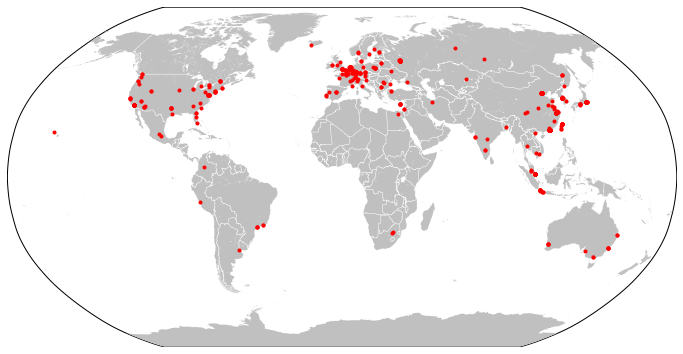

In [26]:
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
plt.figure(figsize=(12,22))
worldMap = Basemap(projection='robin', lon_0=0, resolution='h')
worldMap.drawcountries(color='#ffffff', linewidth=0.5)
worldMap.fillcontinents(color='#c0c0c0', lake_color='#ffffff')
x, y = worldMap(df["lon"].tolist(), df["lat"].tolist())
plt.plot(x, y, 'bo', color = 'r', markersize = 3)
plt.show()